## Setup

In [1]:
import os
import sys

BASE_PATH = "/home/MD00560695/workdir/gradcam"
sys.path.append(BASE_PATH)

In [2]:
DATA_PATH = os.path.join(BASE_PATH, "data/raw/tiny-imagenet-200/")

In [35]:
sample_image = os.path.join(DATA_PATH, "val/images/val_10.JPEG") #"val/cat_dog.png")
val_image_path = os.path.join(DATA_PATH, "val/images")

## Imports

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
# Display
from IPython.display import Image

In [5]:
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [6]:
import tensorflow as tf
from tensorflow.python.framework import ops

In [7]:
tf.__version__ , keras.__version__

('2.3.1', '2.4.0')

## Helper Functions

In [8]:
# Input shape, defined by the model (model.input_shape)
H, W = 224, 224 

In [9]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

In [10]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
def deprocess(x):
    if np.ndim(x) > 3:
        x = np.squeeze(x)
        
    with tf.GradientTape() as tape:
        x = -tf.math.reduce_mean(x)
        x /= (tf.math.reduce_std(x) + 1e-5) 
        x *= 0.1

        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)

        # convert to RGB array
        x *= 25
        if K.image_data_format() == 'th':
            x = x.transpose((1, 2, 0))
            
        x = np.clip(x, 0, 255).astype('uint8')
        
    return x

In [12]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

## Model Definition

In [13]:
def build_model():
    """Function returning keras model instance.
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    return VGG16(include_top=True, weights='imagenet')

## GradCAM

In [14]:
def grad_cam(input_model, image_array, last_conv_layer_name, classifier_layer_names, cls=-1):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # Second, we create a model that maps the activations of the last conv layer 
    # to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(image_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        if cls == -1:
            pred_index = tf.argmax(preds[0])
        else:
            pred_index = cls
        class_channel = preds[:, pred_index]
        #print(class_channel)
        
    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Guided Backprop

In [15]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

In [16]:
def guided_backprop(model, image_array, layer_name, CLASS_INDEX):
    # Create a graph that outputs target convolution and output
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(layer_name).output, model.output])
    
    layer_dict = [layer for layer in grad_model.layers[1:] if hasattr(layer,"activation")]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu
    
    # Get the score for target class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, CLASS_INDEX]
    
    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Apply guided backpropagation
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    
    # Average gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Build a ponderated map of filters according to gradients importance
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for index, w in enumerate(weights):
        cam += w * output[:, :, index]

    return cam

## Salience Mapping

In [17]:
def compute_predictions(model, img_path, top_n = 5):
    """ Compute saliency using all three approaches.
        - layer_name: layer to compute gradients;
        - cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    return 

In [18]:
def compute_saliency(model, img_path, layer_name='block5_conv3', classifier_layers = "predictions", cls=-1, 
                     visualize=True, save=False):
    """ Compute saliency using all three approaches.
        - layer_name: layer to compute gradients;
        - cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)    
    top_1 = [cls]
    if cls == -1:
        cls = np.argmax(predictions)
        top_1 = np.argsort(predictions[0])[-1:][::-1]
    class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    
    print("\nExplanation for '{}' ({})\n".format(class_name, top_1))
    
    # Grad Cam
    #gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gradcam = grad_cam(input_model = model, image_array = preprocessed_input, 
                       last_conv_layer_name = layer_name, classifier_layer_names = classifier_layers,
                      cls=cls)
    
    # We rescale heatmap to a range 0-255
    gradcam_heatmap = np.uint8(255 * gradcam)
    
    # image
    preprocessed_img = preprocessed_input.reshape(224, 224, 3)
    
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[gradcam_heatmap]
    
    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((preprocessed_img.shape[1], preprocessed_img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + preprocessed_img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    

    # Guided Backpropogation
    #gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    gb_cam = guided_backprop(model = model, image_array = preprocessed_input, 
                             layer_name = layer_name, CLASS_INDEX = top_1[0])
    
    # Visualise 
    # We rescale heatmap to a range 0-255
    gb_heatmap = np.uint8(255 * gb_cam)
    
    # We use RGB values of the colormap
    jet_gb_colors = jet(np.arange(256))[:, :3]
    jet_gb_heatmap = jet_colors[gb_heatmap]
    #print(jet_gb_heatmap.shape)
    
    # We create an image with RGB colorized heatmap
    jet_gb_heatmap = keras.preprocessing.image.array_to_img(jet_gb_heatmap)
    jet_gb_heatmap = jet_gb_heatmap.resize((preprocessed_img.shape[1], preprocessed_img.shape[0]))
    jet_gb_heatmap = keras.preprocessing.image.img_to_array(jet_gb_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_gb_img = jet_gb_heatmap * 0.4 + preprocessed_img
    superimposed_gb_img = keras.preprocessing.image.array_to_img(superimposed_gb_img)
    
    
    # Guided Grad CAM
    guided_gradcam = gb_cam * gradcam #gb_cam * gradcam[..., np.newaxis]
    #guided_gradcam = deprocess(guided_gradcam)
    #print(guided_gradcam.shape)
    
    # Visualise Guided GradCAM
    # We rescale heatmap to a range 0-255
    ggb_heatmap = np.uint8(255 * guided_gradcam)
    
    # We use RGB values of the colormap
    jet_ggb_colors = jet(np.arange(256))[:, :3]
    jet_ggb_heatmap = jet_colors[ggb_heatmap]
    
    #print(jet_ggb_heatmap.shape)
    
    # We create an image with RGB colorized heatmap
    jet_ggb_heatmap = keras.preprocessing.image.array_to_img(jet_ggb_heatmap)
    jet_ggb_heatmap = jet_ggb_heatmap.resize((preprocessed_img.shape[1], preprocessed_img.shape[0]))
    jet_ggb_heatmap = keras.preprocessing.image.img_to_array(jet_ggb_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_ggb_img = jet_ggb_heatmap * 0.4 + preprocessed_img
    superimposed_ggb_img = keras.preprocessing.image.array_to_img(superimposed_ggb_img)

    if save:
        #jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        #jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        #cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        # Save the superimposed image
        save_path = "gradcam.jpg"
        superimposed_img.save(save_path)
        save_path = "guidedcam.jpg"
        superimposed_gb_img.save(save_path)
        #cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        #cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(141)
        plt.title('Original Image')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        
        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(superimposed_img)
        
        plt.subplot(143)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(superimposed_gb_img)
        
        plt.subplot(144)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(superimposed_ggb_img)
        #plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(241)
        plt.title('Original Image')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        
        plt.subplot(242)
        plt.title('GradCAM')
        plt.axis('off')
        #plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(243)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(gb_cam, cmap='jet', alpha=0.5)
        
        plt.subplot(244)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(guided_gradcam, cmap='jet', alpha=0.5)
        
        plt.show()
        
    return gradcam, gb_cam, guided_gradcam

## Computing saliency

In [19]:
# define the model
model = build_model()

In [20]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "predictions",
]

In [36]:
compute_predictions(model, sample_image, top_n = 5)

Model prediction:
	fireboat       	(554)	with probability 0.262
	container_ship 	(510)	with probability 0.161
	liner          	(628)	with probability 0.093
	breakwater     	(460)	with probability 0.046
	crane          	(517)	with probability 0.040



Explanation for 'fireboat' ([554])



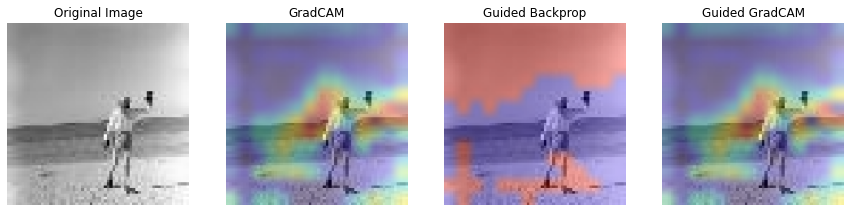

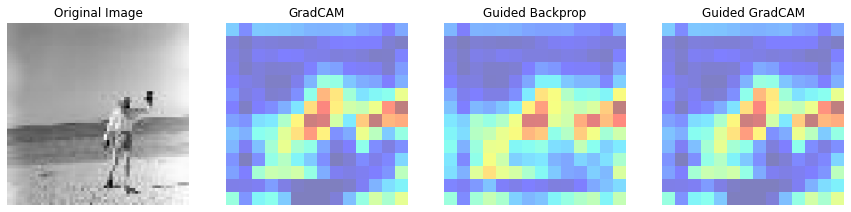

In [37]:
gradcam, gb, ggb = compute_saliency(model, sample_image, 
                                    layer_name = last_conv_layer_name, classifier_layers = classifier_layer_names, 
                                    cls=-1, visualize=True, save=False)


Explanation for 'crane' ([517])



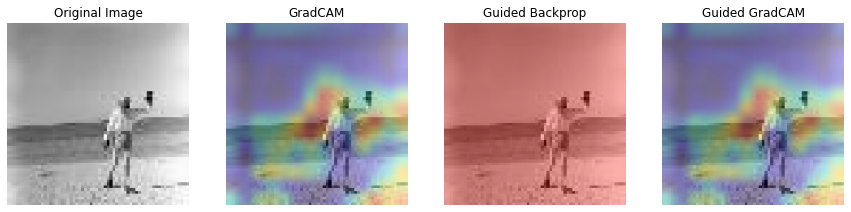

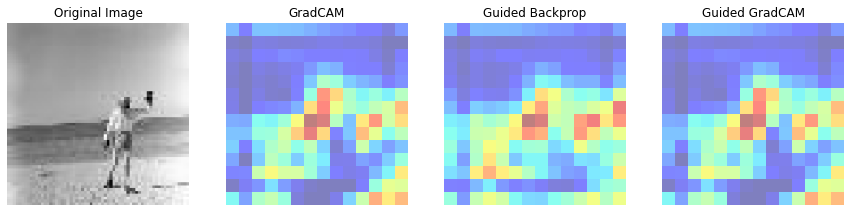

In [39]:
gradcam, gb, ggb = compute_saliency(model, sample_image, 
                                    layer_name = last_conv_layer_name, classifier_layers = classifier_layer_names, 
                                    cls=517, visualize=True, save=False)